<a href="https://colab.research.google.com/github/dheerajreddy2020/Facial-Landmarks-Detection/blob/main/Facial_Landmarks_Detection_Applied_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Drive
from google.colab import drive

In [ ]:
# Mounting Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
import os

## Importing Dataset
* Dataset Reference Link : https://www.tensorflow.org/datasets/catalog/aflw2k3d
* Data Main Source :  http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/main.htm

**Description** :
AFLW2000-3D is a dataset of 2000 images that have been annotated with image-level 68-point 3D facial landmarks. This dataset is typically used for evaluation of 3D facial landmark detection models. The head poses are very diverse and often hard to be detected by a cnn-based face detector. The 2D landmarks are skipped in this dataset, since some of the data are not consistent to 21 points, as the original paper mentioned.




In [ ]:
# Load neccesary libraries to import dataset
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset as numpy array
ds = tfds.as_numpy(tfds.load(
    'aflw2k3d',
    split='train',
    batch_size=-1,
))

In [ ]:
# Understanding the numpy array
for key in ds.keys():
  print(key , ds[key].shape, ds[key].max())

image (2000, 450, 450, 3) 255
landmarks_68_3d_xy_normalized (2000, 68, 2) 1.2392322
landmarks_68_3d_z (2000, 68, 1) 249.44214


## Prepare Inputs and Outputs

In [ ]:
X = ds['image']
#X = np.array(X)
y = ds['landmarks_68_3d_xy_normalized']
print(y.shape)
y = y.reshape(-1, y.shape[1]*y.shape[2])
print(y.shape)

(2000, 68, 2)
(2000, 136)


* From the above result it is understood that the dataset consists of 2000 images
* Each image has a shape of (450,450,3)
* Y has 68 keypoints which are being converted to a singe vector for each image

* **Model input shape should be (None,450,450,3)**
* **Model output shape should be (None,136)**

## Data exploration:
* Plotting the key points on the faces in the dataset

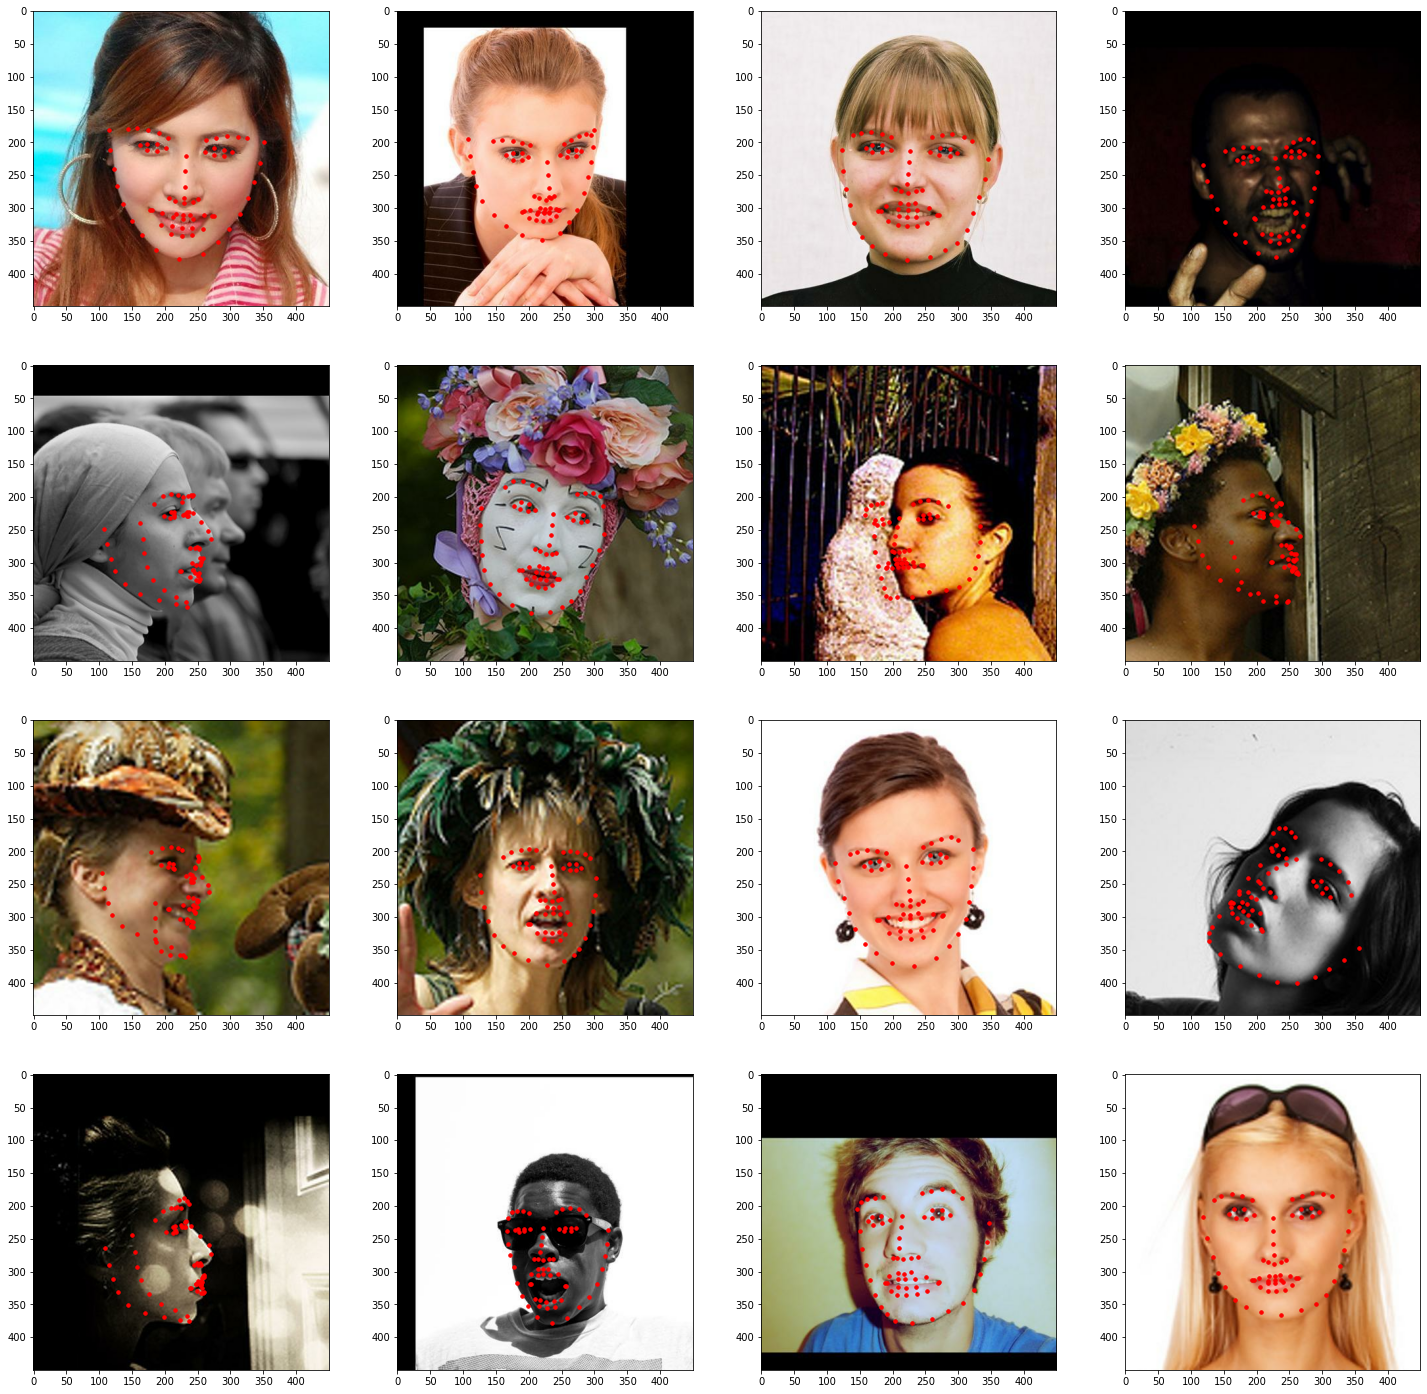

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
# Defining the number of subplots
fig, ax = plt.subplots(4, 4,figsize=(25,25))
for i in range(4):
  for j in range(4):
    nr=np.random.randint(0,1999)
    ax[i,j].imshow(X[nr])
    # Multiply the data points with image size as the x,y co-ordinates are normalized 
    for element in ds['landmarks_68_3d_xy_normalized'][nr]*X.shape[1]:
        ax[i,j].scatter(element[0],element[1],c='r',s=12)

## Feature Extractor Selection
* Since the dataset conssists of just 2000 images, a transfer learning method will be used to extract the features of the face
* There a number of pre trained modes to extract features from the face in the link https://keras.io/api/applications/
* In this assignment Xception based feature extractor will be used, the main reasons for choosing that are listed below
  1. Relatively same or better performance on ImageNet classes compared to many stat of the art DL models.
  2. Lower number of parameters compared to VGG and Inception.
  3. So faster training and prediction.
  4. Setting the convolutional block to trainable variables, so that any new features can be learned.

In [ ]:
# Exploring Xception model
from keras.applications import Xception

feature_extractor = Xception(weights='imagenet', include_top = False, input_shape=(450,450,3))
for layer in feature_extractor.layers:
  layer.trainable = False
  if layer.name == 'block13_sepconv1_act':
    break
feature_extractor.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 450, 450, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 224, 224, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 224, 224, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization,GlobalAveragePooling2D
from keras.models import Model
x_input = feature_extractor.output
x = GlobalAveragePooling2D(name = 'Global_average_pooling')(x_input)
x = Dropout(0.1, name = 'Dropout_1')(x)
#x = Flatten()(x)
#x = Dense(1024,  name = 'first_dense')(x)
#x = Dropout(0.1, name = 'Dropout_2')(x)
#x = LeakyReLU(alpha=0.1, name ='leaky_relu_activation_1')(x)
x = Dense(512,  name = 'second_dense')(x)
x = Dropout(0.1, name = 'Dropout_3')(x)
x = LeakyReLU(alpha=0.1, name ='leaky_relu_activation_2')(x)
# last layer activation is Relu, as we are trying to predict the regression 
x = Dense (136, name = 'softmax')(x)
#x_input = Input([None,450,450,3])
model = Model(feature_extractor.input,x)
model.summary()

model.compile(loss='mse', optimizer='adam', metrics =['accuracy'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 450, 450, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 224, 224, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 224, 224, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = X_train/255.
X_test = X_test/255.

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

import math
def step_decay(epoch):
	initial_lr = 0.01
	drop = 0.5
	epochs_drop = 5
	lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lr

lr_rate_control = LearningRateScheduler(step_decay, verbose=1)
early_stopping=EarlyStopping(monitor='val_accuracy',patience=15)
callbacks=[early_stopping,lr_rate_control]

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1)

Epoch 1/50
50/50 [==============================] - 27s 454ms/step - loss: 0.0993 - accuracy: 0.1261 - val_loss: 0.0190 - val_accuracy: 0.6950
Epoch 2/50
50/50 [==============================] - 21s 421ms/step - loss: 0.0168 - accuracy: 0.2033 - val_loss: 0.0264 - val_accuracy: 0.6950
Epoch 3/50
50/50 [==============================] - 21s 416ms/step - loss: 0.0092 - accuracy: 0.2180 - val_loss: 0.0129 - val_accuracy: 0.6925
Epoch 4/50
50/50 [==============================] - 21s 416ms/step - loss: 0.0061 - accuracy: 0.2479 - val_loss: 0.0054 - val_accuracy: 0.5100
Epoch 5/50
50/50 [==============================] - 21s 416ms/step - loss: 0.0048 - accuracy: 0.2136 - val_loss: 0.0030 - val_accuracy: 0.6275
Epoch 6/50
50/50 [==============================] - 21s 416ms/step - loss: 0.0039 - accuracy: 0.2711 - val_loss: 0.0024 - val_accuracy: 0.6225
Epoch 7/50
50/50 [==============================] - 21s 416ms/step - loss: 0.0039 - accuracy: 0.2801 - val_loss: 0.0025 - val_accuracy: 0.6150

In [ ]:
# Save the Model
os.chdir('/content/drive/MyDrive/Colab Notebooks')
model.save('Facial_landmarks_detection.h5')

## Loading the pre-trained model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.models import load_model
import os

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')
model = load_model('Facial_landmarks_detection.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 450, 450, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 224, 224, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 224, 224, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

## Displaying predictions on random images from test dataset

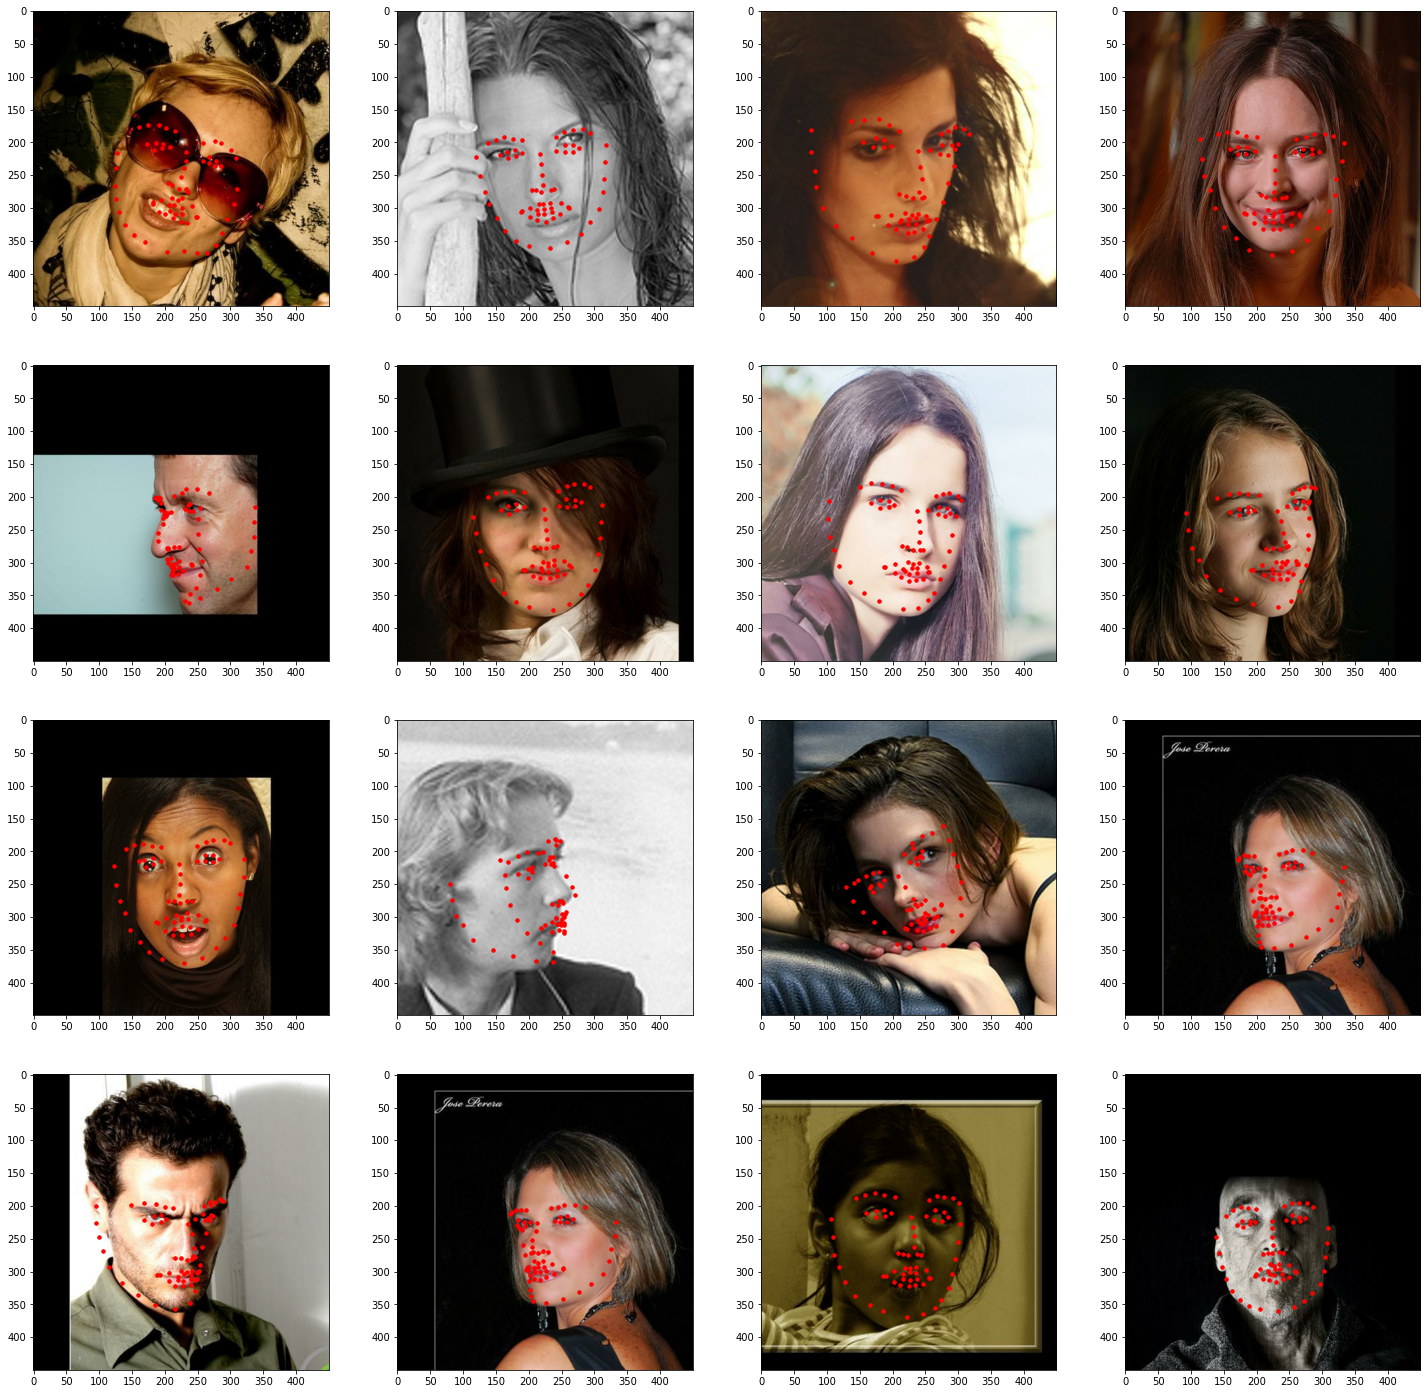

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
# Data exploration
fig, ax = plt.subplots(4, 4,figsize=(25,25))
for i in range(4):
  for j in range(4):
    nr=np.random.randint(0,399)
    ax[i,j].imshow(X_test[nr])
    land_marks = model.predict(np.expand_dims(X_test[nr],axis=0))
    land_marks = land_marks.reshape(68,2)
    # Multiply the data points with image size as the x,y co-ordinates
    for element in land_marks*450:
        ax[i,j].scatter(element[0],element[1],c='r',s=12)

## Sample Predictions on my facial images

In [ ]:
# Upload your own Facial Images
from google.colab import files
uploaded = files.upload()
path = []
for fn in uploaded.keys():
  path.append(os.getcwd()+'/'+fn)

Saving face-3.jpg to face-3.jpg
Saving face-2.jpg to face-2.jpg
Saving face-1.jpg to face-1.jpg


* Please don't run the below code as the inferences are given based on this output

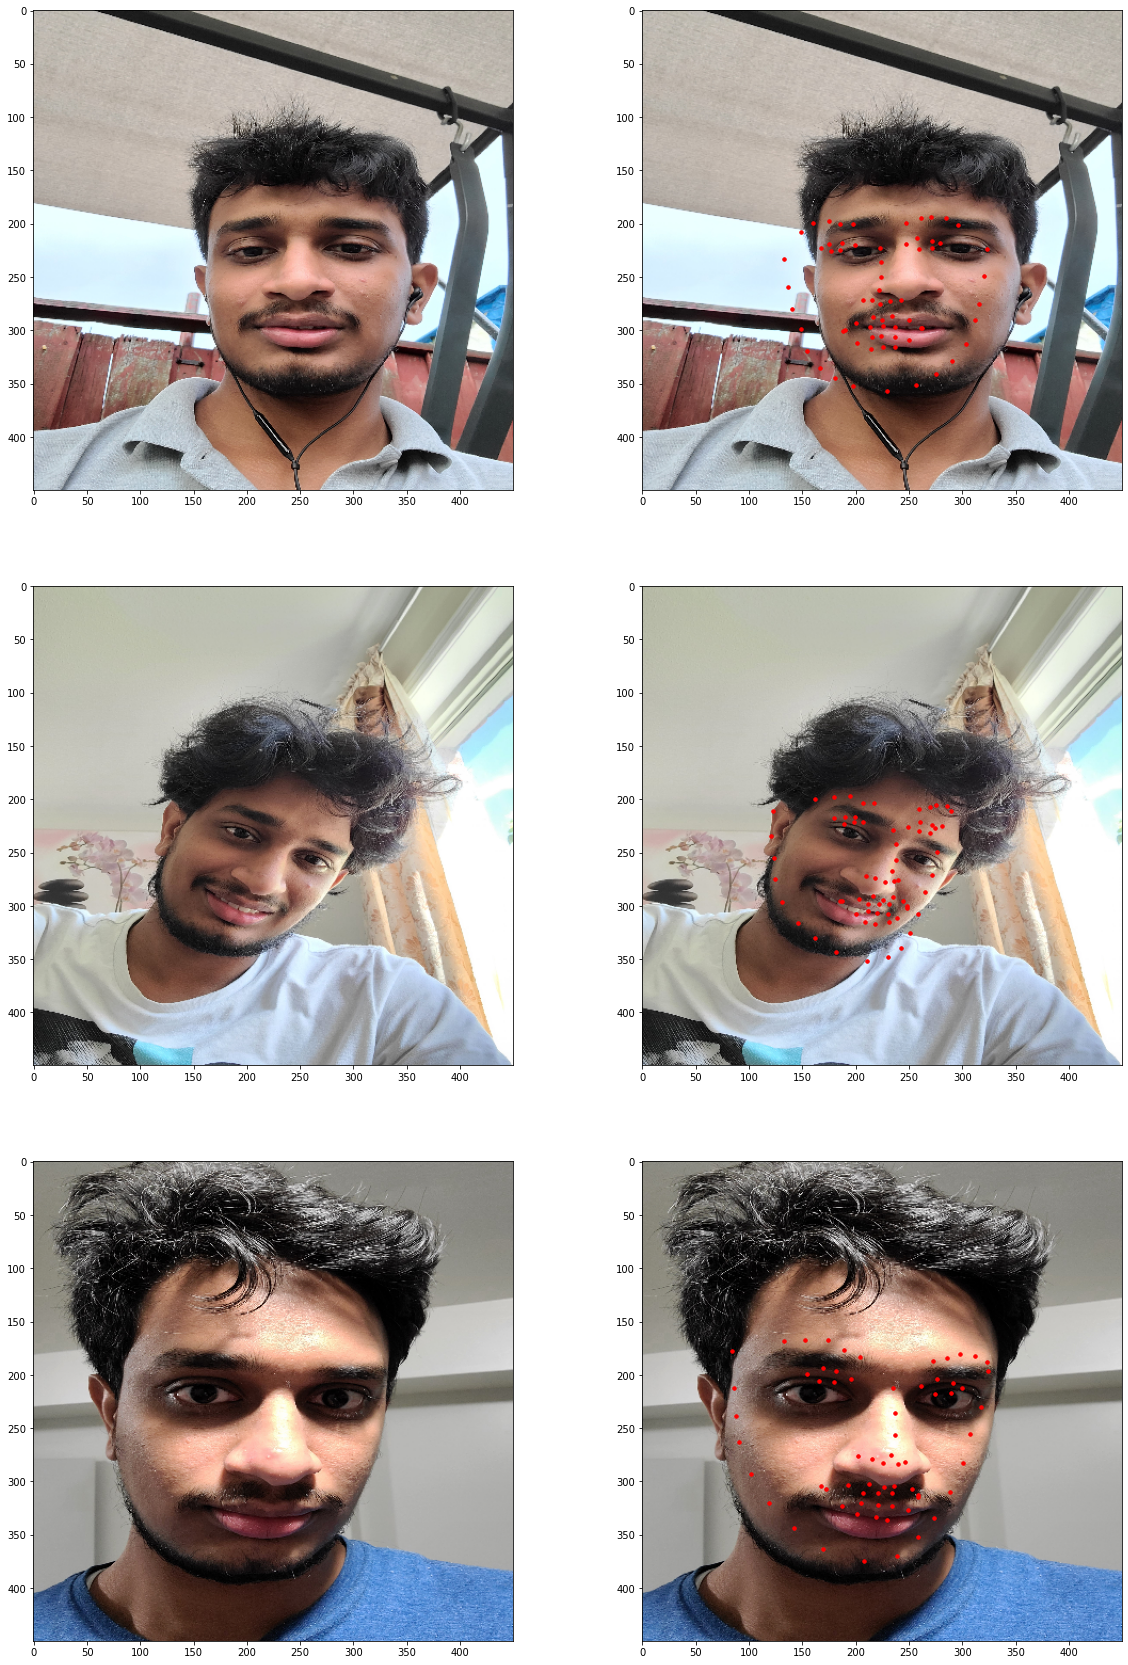

In [ ]:
# Predictions for your facial images
from keras.preprocessing import image
import cv2
#uploaded = files.upload()
fig, ax = plt.subplots(len(path), 2,figsize=(20,30))
i = 0
j = 0
for floc in path:
  img_bgr = cv2.imread(floc)
  img_bgr = cv2.resize(img_bgr,(450,450))
  img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  ax[i,j].imshow(img)
  j = j+1
  ax[i,j].imshow(img)
  img=img/255.
  x = image.img_to_array(img)
  x = np.expand_dims(x,axis=0)
  facial_points = model.predict(x)
  facial_points = facial_points.reshape(68,2)
  for element in facial_points*450:
        ax[i,j].scatter(element[0],element[1],c='r',s=12)
  j = 0
  i += 1

## Summary

* As you can see that there is a major offset in the predictions, especially when the head is tilted.
* This problem can be addressed by increasing the training dataset